# Autoencoders on CIFAR-10

## Task Description

We have seen how to build an Autoencoder for the grayscale images of the Fashion-MNIST dataset. In this Exercise, you will build one for the CIFAR-10 dataset (https://www.cs.toronto.edu/~kriz/cifar.html). This dataset contains **color** images with a 32x32 resolution.

### Preparation


In [1]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()



In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models, datasets, callbacks
import tensorflow.keras.backend as K



2025-12-16 16:09:22.085361: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-16 16:09:22.085786: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-16 16:09:22.140490: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-16 16:09:23.334744: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 128
EPOCHS = 20

## 1. Prepare the data <a name="prepare"></a>

In [4]:
# Load the data
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

In [5]:
# Preprocess the data

def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype("float32") / 255.0
    imgs = imgs.reshape(len(imgs),imgs.shape[1],imgs.shape[2],3)
    return imgs


x_train = preprocess(x_train)
x_test = preprocess(x_test)

In [ ]:
# Show some items of clothing from the training set
display(x_train)

## 2. Build the autoencoder <a name="build"></a>

In [6]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(32, (3, 3), strides=2, activation="relu", padding="same")(
    encoder_input
)
x = layers.Conv2D(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation="relu", padding="same")(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
encoder_output = layers.Dense(EMBEDDING_DIM, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

2025-12-16 16:09:53.983600: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │       262,272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,520 (1.36 MB)

 Trainable params: 355,520 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Decoder
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)
decoder_output = layers.Conv2D(
    CHANNELS,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 504,899 (1.93 MB)

 Trainable params: 504,899 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Autoencoder
autoencoder = models.Model(
    encoder_input, decoder(encoder_output)
)  # decoder(encoder_output)
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 3)      │       504,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 860,419 (3.28 MB)

 Trainable params: 860,419 (3.28 MB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the autoencoder <a name="train"></a>

In [9]:
# Compile the autoencoder
autoencoder.compile(optimizer="adam", loss="mse")

In [10]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint.keras",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [11]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, x_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback],
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 149ms/step - loss: 0.0185 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 145ms/step - loss: 0.0084 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 142ms/step - loss: 0.0068 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 143ms/step - loss: 0.0058 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 148ms/step - loss: 0.0054 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 144ms/step - loss: 0.0052 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 143ms/step - loss: 0.0050 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - loss: 0.0049 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - loss: 0.0048 - val_loss: 0.0048 - learn

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 76s 149ms/step - loss: 0.0185 - val_loss: 0.0101 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 80s 145ms/step - loss: 0.0084 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 142ms/step - loss: 0.0068 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 71s 143ms/step - loss: 0.0058 - val_loss: 0.0055 - learning_rate: 0.0010
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 148ms/step - loss: 0.0054 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 144ms/step - loss: 0.0052 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 72s 143ms/step - loss: 0.0050 - val_loss: 0.0050 - learning_rate: 0.0010
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 74s 148ms/step - loss: 0.0049 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - loss: 0.0048 - val_loss: 0.0048 - learn

In [12]:
# Save the final models
from pathlib import Path
Path("./models").mkdir(parents=True, exist_ok=True)
autoencoder.save("./models/autoencoder.keras")
encoder.save("./models/encoder.keras")
decoder.save("./models/decoder.keras")

## 4. Reconstruct using the autoencoder <a name="reconstruct"></a>

In [13]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Example real images


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Example real images


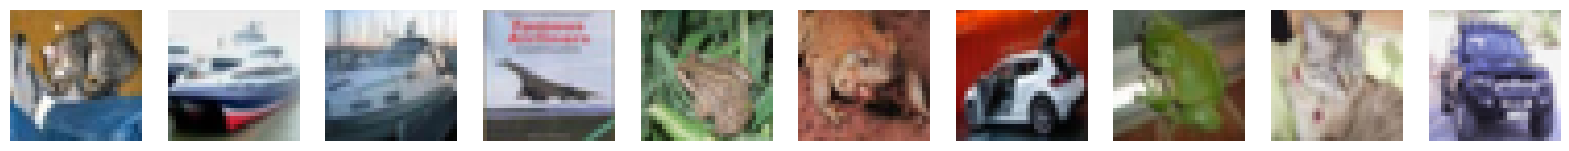

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Example real images


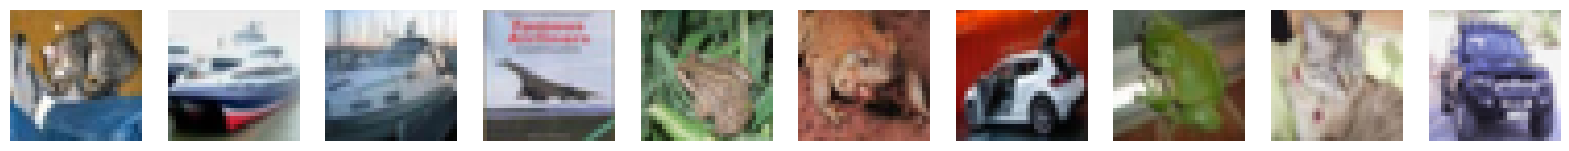

Reconstructions


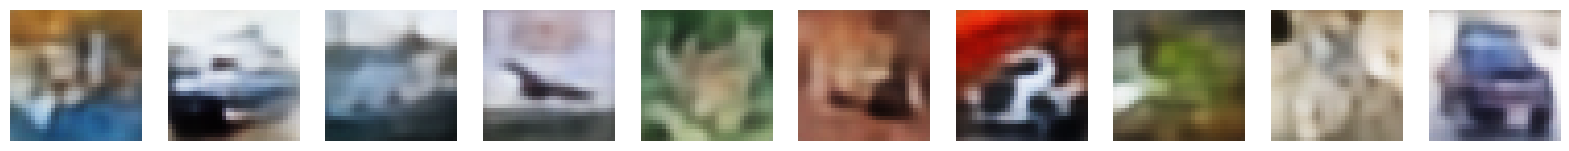

In [14]:
predictions = autoencoder.predict(example_images)

print("Example real images")
display(example_images)
print("Reconstructions")
display(predictions)

## 5. Embed using the encoder <a name="encode"></a>

In [15]:
# Encode the example images
embeddings = encoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [16]:
# Some examples of the embeddings
print(f"Embedding shape: {embeddings.shape}")
print(f"First 3 embeddings (showing first 10 dimensions only):")
print(embeddings[:3, :10])

Embedding shape: (5000, 128)
First 3 embeddings (showing first 10 dimensions only):
[[-0.4251433  -0.46777058 -0.5634063   0.73067516 -0.57027483  0.33225346
  -0.11835911  0.9395472   0.46951997  0.25794902]
 [-0.20121898  0.09431175 -0.5325394   2.2727625   0.9478851   3.1118774
  -0.40407056  2.3691165  -1.2495315   0.21542427]
 [ 0.28769732 -0.50875425 -0.7269342   1.4973098  -0.5416137   1.5899168
  -0.9504108   1.2556534  -0.6525851   0.265314  ]]


### Dimensionality Reduction with UMAP

Since we have 128-dimensional embeddings, we can't directly visualize them in 2D. We'll use UMAP (Uniform Manifold Approximation and Projection) to reduce the dimensionality while preserving the structure of the data.

In [17]:
# Install umap-learn if not already installed
import subprocess
import sys

try:
    import umap
except ImportError:
    print("Installing umap-learn...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
    import umap

print(f"UMAP version: {umap.__version__}")

/workspaces/cas-uzh/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/workspaces/cas-uzh/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


UMAP version: 0.5.9.post2


In [18]:
# Reduce embeddings from 128D to 2D using UMAP
print("Reducing dimensionality from 128D to 2D using UMAP...")
reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embeddings_2d = reducer.fit_transform(embeddings)
print(f"Reduced embedding shape: {embeddings_2d.shape}")

Reducing dimensionality from 128D to 2D using UMAP...


/workspaces/cas-uzh/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reducing dimensionality from 128D to 2D using UMAP...


/workspaces/cas-uzh/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reduced embedding shape: (5000, 2)


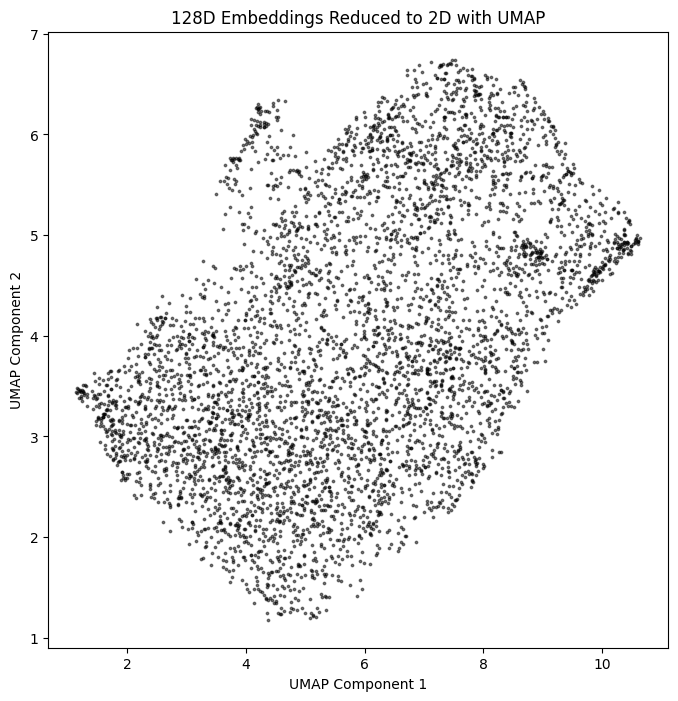

In [19]:
# Show the encoded points in 2D space (after UMAP reduction)
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c="black", alpha=0.5, s=3)
plt.title("128D Embeddings Reduced to 2D with UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

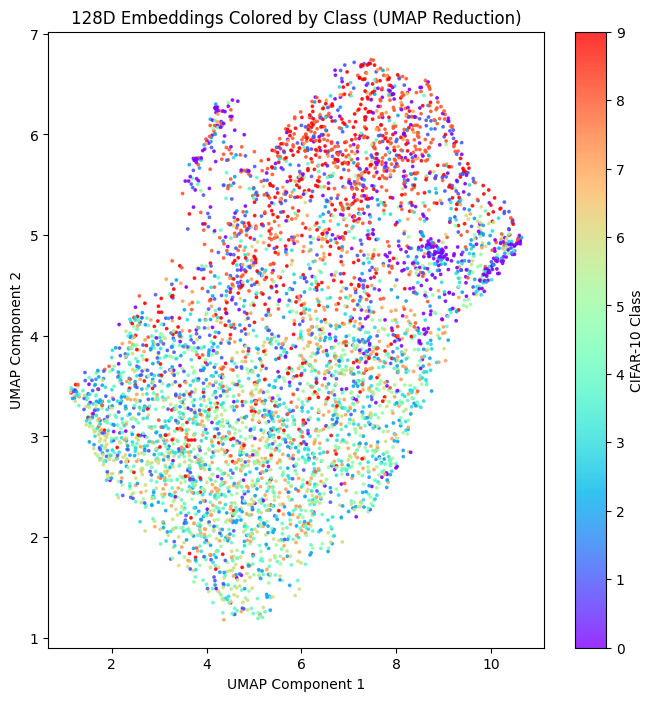

In [20]:
# Colour the embeddings by their label
example_labels = y_test[:n_to_predict]

figsize = 8
plt.figure(figsize=(figsize, figsize))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    cmap="rainbow",
    c=example_labels,
    alpha=0.8,
    s=3,
)
plt.colorbar(scatter, label="CIFAR-10 Class")
plt.title("128D Embeddings Colored by Class (UMAP Reduction)")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

## 6. Results

### Training
- Started: Loss 0.0185 → Val Loss 0.0101
- Ended: Loss 0.0043 → Val Loss 0.0044
- Improvement: 91% reduction in validation loss! (vs. 56% with binary_crossentropy)

### Learning Rate Scheduler in Action
- Epoch 12: LR reduced from 0.001 → 0.0005 (first plateau)
- Epoch 16: LR reduced to 0.00025 (second plateau)
- Epoch 19: LR reduced to 0.000125 (third plateau)

### Comparison with v2
- Much better reconstruction - MSE loss is ~100x better than before (0.0044 vs 0.56)
- Automatic learning rate tuning - optimizes training without manual intervention
- Ready for longer training - could increase EPOCHS to 50+ and it will auto-stop when needed, however much more expensive computationally